(ch2:select)=
# Select and Train a Model

So, now you've got your data loaded and pre-processed... what next? Let's get all the code in that we've used so far:

In [72]:
import os
import urllib
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from graspologic.utils import import_edgelist, pass_to_ranks
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

# the AWS bucket the data is stored in
BUCKET_ROOT = "open-neurodata"
# the path to the data we are interested in
FMRI_PREFIX = "m2g/Functional/BNU1-11-12-20-m2g-func/Connectomes/Glasser_space-MNI152NLin6_res-2x2x2.nii.gz/"
FMRI_PATH = os.path.join("datasets", "fmri")  # the output folder
DS_KEY = "abs_edgelist"  # correlation matrices for the networks to exclude

def fetch_fmri_data(bucket=BUCKET_ROOT, fmri_prefix=FMRI_PREFIX,
                    output=FMRI_PATH, name=DS_KEY):
    """
    A function to fetch fMRI connectomes from AWS S3.
    """
    # check that output directory exists
    if not os.path.isdir(FMRI_PATH):
        os.makedirs(FMRI_PATH)
    # start boto3 session anonymously
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    # obtain the filenames
    bucket_conts = s3.list_objects(Bucket=bucket, 
                    Prefix=fmri_prefix)["Contents"]
    for s3_key in bucket_conts:
        # get the filename
        s3_object = s3_key['Key']
        # verify that we are grabbing the right file
        if name not in s3_object:
            op_fname = os.path.join(FMRI_PATH, str(s3_object.split('/')[-1]))
            if not os.path.exists(op_fname):
                s3.download_file(bucket, s3_object, op_fname)

def read_fmri_data(path=FMRI_PATH):
    """
    A function which loads the connectomes as adjacency matrices.
    """
    networks = [import_edgelist(os.path.join(path, fname)) for fname in os.listdir(path)]
    return np.stack(networks, axis=0)

def remove_isolates(A):
    """
    A function which removes isolated nodes from the 
    adjacency matrix A.
    """
    degree = A.sum(axis=0)  # sum along the rows to obtain the node degree
    out_degree = A.sum(axis=1)
    A_purged = A[~(degree == 0),:]
    A_purged = A_purged[:,~(degree == 0)]
    print("Purging {:d} nodes...".format((degree == 0).sum()))
    return A_purged

class CleanData(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X):
        return self

    def transform(self, X):
        print("Cleaning data...")
        Acleaned = remove_isolates(A)
        A_abs_cl = np.abs(Acleaned)
        self.A_ = A_abs_cl
        return self.A_
    
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        print("Scaling edge-weights...")
        A_scaled = pass_to_ranks(X)
        return (A_scaled)

num_pipeline = Pipeline([
    ('cleaner', CleanData()),
    ('scaler', FeatureScaler()),
])

Cleaning data...
Purging 0 nodes...
Scaling edge-weights...


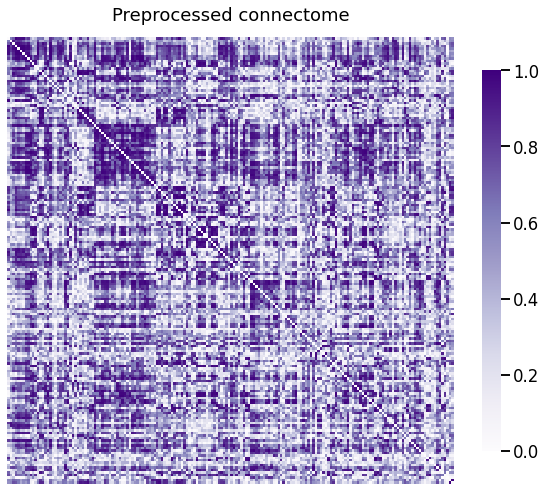

In [76]:
fetch_fmri_data()
As = read_fmri_data()
A = As[0]

A_xfm = num_pipeline.fit_transform(A)
heatmap(A_cleaned, title="Preprocessed connectome", vmin=0, vmax=1);

## Generating new representations from your data

As you were briefly introduced to in [what is network machine learning?](ch1:whatis) and will cover more thoroughly in [learning network representations](ch6), a major problem with learning from network data is that, inherently, networks in their rawest form are not tabular datasets. This means that if you want to apply any of the breadth of knowledge that has been acquired in general machine learning (which is typically designed for tabular datasets), you need to learn how to adapt your network to be compatible with tabular approaches, or learn how to adapt your general machine learning architecture for network layouts, such as adjacency matrices, which properly convey the dependences in network data. 

As you will learn, particularly in the end of this book in [chapter 10](ch10), the former is possible, but generally a bit more involved. The latter approach tends to be, in our opinions, a bit more straightforward at first, and is usually fantastic for most applications. So, how do you obtain a tabular representation of your dataset? 

Well, one possible thing you can do is you can use something called a [spectral embedding](ch6:spectral), a technique that you will learn has a wide range of applications in network machine learning whether you are studying one network, pairs of networks, or multiple networks. Let's see what happens when we spectrally embed our connectome:

In [77]:
embedding = gp.embed.AdjacencySpectralEmbed().fit_transform(A_xfm)

An *embedding* takes the adjacency matrix, which is a matrix representation of the entire network, and turns it into a tabular array. Each row is called an *estimated latent position* for a given node, and each column is called an *estimated latent dimension* of the network. This means that if there are $n$ nodes, there are $n$ rows of the spectral embedding, and if there are $d$ estimated latent dimensions of the network, there are $d$ columns. Overall, the spectral embedding has taken the $n \times n$ adjacency matrix, which we *can't* inherently use network machine learning algorithms on, and *transformed* it into a $n \times d$ tabular array, which we *can* inherently use machine learning algorithms on. We'll visualize this embedding using a *pairs plot*, which as you will learn later, is a scatter plot showing where each node is a single point in the plot, and the x and y axes are different *pairs* of latent dimensions for that particular node:

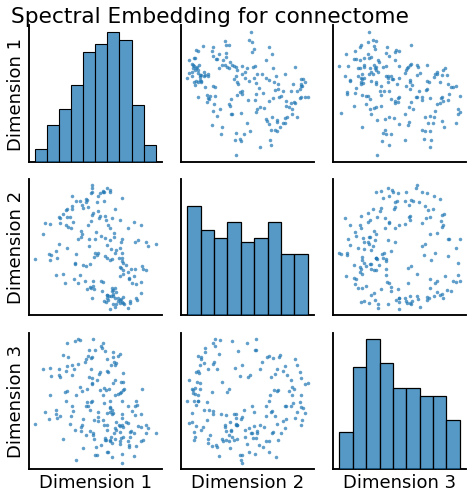

In [80]:
_ = gp.plot.pairplot(embedding, title="Spectral Embedding for connectome")

As it turns out, this particular representation of the adjacency matrix through the *spectral embedding* can, optionally, be tied into a statistical model if you make some assumptions; particularly, those of the [stochastic block model](ch5:sbm), which you will learn about in chapter 5. Basically, what the stochastic block model says is that each node is a member of a subgroup, called a *community*, and its connectivity to other nodes in the network is dictated by which community it is a member of, and which community the other node is a member of. This sounds a *lot* like the question that your colleague wanted you to approach, since he wanted a way to take the nodes of the network and form "functionally similar" subgroups from them. 

Now that we have a tabular representation of the data, we can take attempt to use the intuition and assumptions of the stochastic block model to cluster our nodes. Let's see what happens when we apply $k$-means to our data:

In [81]:
from sklearn.cluster import KMeans

labels = KMeans(n_clusters=2).fit_predict(embedding)

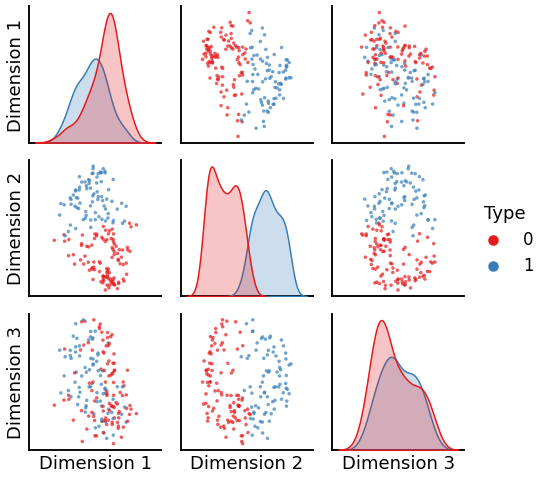

In [82]:
_ = gp.plot.pairplot(embedding, labels=labels)

So, it looks like the $k$-means was able to learn $2$ clusters from our dataset. 